In [1]:
from install import *
install_requirements(chapter=2)

⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.33.1
Using datasets v2.17.1
Using accelerate v0.27.2
Using sentencepiece
Using umap v0.5.6


## 데이터셋

이 데이터셋은 분노, 혐오, 두려움, 기쁨, 슬픔, 놀람 여섯 개의 감정으로 구성됨.

### 허깅페이스 데이터셋 사용하기

In [2]:
from huggingface_hub import list_datasets

all_datasets = [ds.id for ds in list_datasets()]
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있다.")
print(f"처음 10개 데이터셋: {all_datasets[:10]}")

현재 허브에는 204851개의 데이터셋이 있다.
처음 10개 데이터셋: ['amirveyseh/acronym_identification',
'ade-benchmark-corpus/ade_corpus_v2', 'UCLNLP/adversarial_qa',
'Yale-LILY/aeslc', 'nwu-ctext/afrikaans_ner_corpus', 'fancyzhx/ag_news',
'allenai/ai2_arc', 'google/air_dialogue', 'komari6/ajgt_twitter_ar',
'legacy-datasets/allegro_reviews']


load_dataset() 함수로 emotion 데이터셋 로드

In [3]:
from datasets import load_dataset

emotion = load_dataset("emotion")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

이 객체는 파이썬 딕셔너리와 비슷하다.

In [5]:
train_ds = emotion["train"]
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


이 경우 text열의 데이터 타입은 string이고, label열은 클래스 이름과 정수 매핑에 대한 정보가 담긴 특별한 ClassLabel 객체이다.

In [6]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


### 데이터셋에서 데이터프레임으로

Dataset 객체를 판다스 데이터프레임으로 변환하는 것이 편리할 때가 많다.  
이러한 변환을 위해 허깅페이스 데이터셋은 Dataset의 출력 포맷을 변경하는 `set_format()`메서드를 제공한다.

In [8]:
import pandas as pd

emotion.set_format(type="pandas")
df = emotion["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


레이블이 정수로 출력되므로 features 속성으로 label열을 선택한 후 int2str() 메서드로 레이블 이름에 해당하는 새로운 열을 데이터프레임에 추가하자.

In [9]:
def label_int2str(row):
    return emotion["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


안드레이 카패시는 좋은 모델을 훈련하려면 반드시 '데이터와 하나가 되어야'한다고 말했다.

### 클래스 분포 살펴보기

분류 문제를 다룰 때는 언제나 샘플의 클래스 분포를 조사하는 것이 좋다.

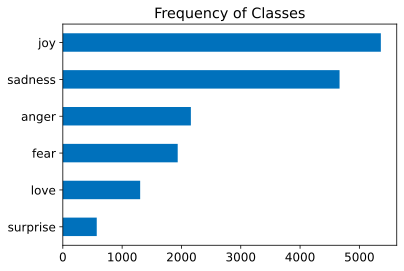

In [10]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

이 데이터셋은 불균형이 심하다. 불균형한 데이터는 다음 방법으로 다룬다.
- 소수 클래스를 랜덤하게 오버샘플링한다.
- 다수 클래스를 랜덤하게 언더샘플링한다.

### 트윗 길이 확인

트랜스포머 모델은 **최대 문맥 크기**라는 최대 입력 시퀀스 길이가 있다.  
예제에서 사용하는 DistilBERT 모델의 최대문맥크기는 512토큰이다.
트윗당 단어 분포를 보면 감정에 따른 트윗 길이가 대략 추정된다.

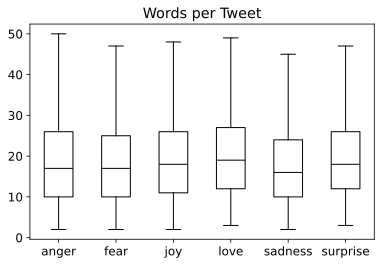

In [12]:
df["Words per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per Tweet", by="label_name", grid=False, showfliers=False, color="black")

plt.suptitle("")
plt.xlabel("")
plt.show()

각 감정의 트윗 길이는 15개 단어 정도로 모델의 최대문맥크기보다 더 작다.  

이제 더이상 데이터프레임 포맷이 필요하지 않으니 데이터셋의 출력 포맷을 초기화하자.

In [13]:
emotion.reset_format()

## 텍스트에서 토큰으로

적용할 수 있는 토큰화 전략이 몇 가지 있으며 단어를 부분단위로 나누기 위한 최적 분할은 일반적으로 말뭉치에서 학습된다.  
문자 토큰화와 단어 토큰화라는 두 가지 방식을 살펴보자.

### 문자 토큰화

가장 간단한 토큰화 방법은 각 문자를 개별로 모델에 주입하는 것.

In [14]:
text = "Tokenizing text is a core task of NLP"
tokenized_text = list(text)

print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P']


모델은 각 문자가 정수로 변환되리라 기대한다. 이런 과정을 `수치화`라 한다. 가장 쉬운 방법은 고유한 각 토큰을 고유한 정후로 인코딩하는 것.

In [16]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'L': 1, 'N': 2, 'P': 3, 'T': 4, 'a': 5, 'c': 6, 'e': 7, 'f': 8, 'g': 9,
'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17, 'z': 18}


어휘사전에 있는 각 문자를 고유한 정수로 바꾸는 매핑 딕셔너리를 만들자. 이제 token2idx를 사용해 토큰화된 텍스트를 정수 리스트로 변환한다.

In [17]:
input_ids = [token2idx[token] for token in tokenized_text]

print(input_ids)

[4, 13, 11, 7, 12, 10, 18, 10, 12, 9, 0, 16, 7, 17, 16, 0, 10, 15, 0, 5, 0, 6,
13, 14, 7, 0, 16, 5, 15, 11, 0, 13, 8, 0, 2, 1, 3]


마지막 단계로 input_ids를 원핫벡터의 2D텐서로 바꾸자.

In [18]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))

one_hot_encodings.shape

torch.Size([37, 19])

문자 수준의 토큰화는 텍스트의 구조를 무시하고 전체 문자열을 문자 스트림으로 처리한다는 것을 확인했다.  
이 방식은 철자 오류나 희귀한 단어를 처리하는 데 유용하지만, 단어 같은 언어 구조를 이 데이터에서 학습해야 한다는 큰 단점이 있다.  
이를 위해서는 상당량의 계산, 메모리, 데이터가 필요하다.  
대신, 텍스트의 일부 구조가 유지되는 토큰화를 사용한다. 